Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [62]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input, Rescaling, RandomFlip, RandomRotation, RandomZoom, BatchNormalization
from keras.models import Sequential
from glob import glob


In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/Assignment-Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/Assignment-Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=batch_size, image_size=(img_height, img_width), seed=123, validation_split=0.2, subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


2024-12-16 22:27:04.669034: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-12-16 22:27:04.669059: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-12-16 22:27:04.669073: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-12-16 22:27:04.669090: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-16 22:27:04.669104: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=batch_size, image_size=(img_height, img_width), seed=123, validation_split=0.2, subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

2024-12-16 22:27:07.530800: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


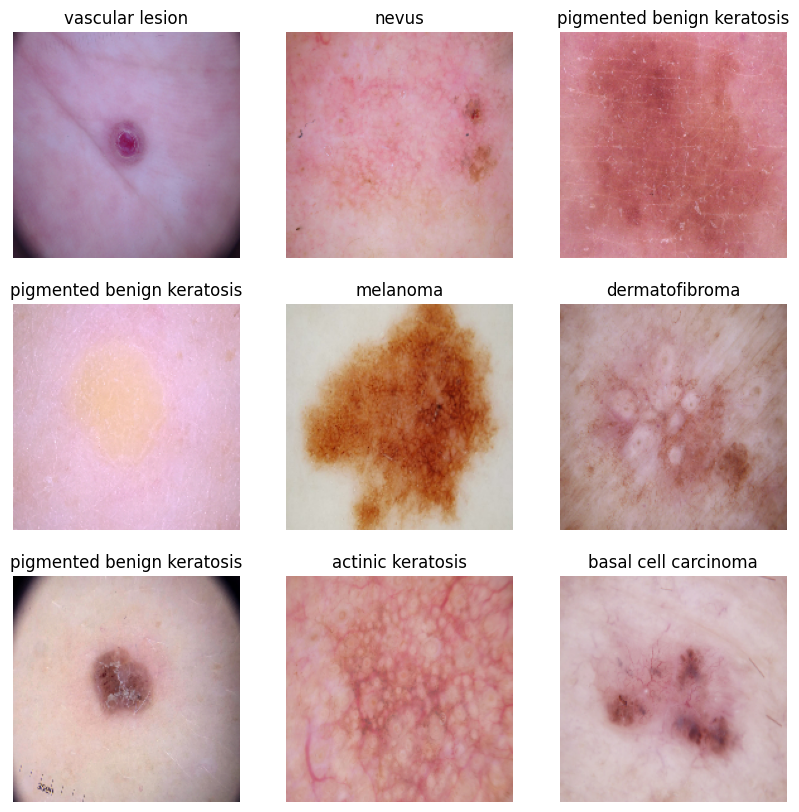

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [25]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [26]:
### Your code goes here
num_classes = len(class_names)
model = Sequential()

# Input Layer
model.add(Input(shape=(img_height, img_width, 3)))
model.add(Rescaling(1./255))

# Block 1
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [27]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
# View the summary of all layers
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 129600)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    16,588,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,609,481 (63.36 MB)

 Trainable params: 16,609,481 (63.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [29]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  shuffle=True
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.1785 - loss: 5.8448 - val_accuracy: 0.2438 - val_loss: 1.9598
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.2540 - loss: 1.9773 - val_accuracy: 0.2864 - val_loss: 1.8478
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.3609 - loss: 1.7422 - val_accuracy: 0.4474 - val_loss: 1.5919
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.4627 - loss: 1.4979 - val_accuracy: 0.4899 - val_loss: 1.6280
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.5194 - loss: 1.3839 - val_accuracy: 0.4116 - val_loss: 1.5703
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.5255 - loss: 1.3154 - val_accuracy: 0.4720 - val_loss: 1.5690
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.5795 - loss: 1.1902 - val_accuracy: 0.5324 - val_loss: 1.5838
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.5924 - loss: 1.1257 - val_accuracy: 0.5168 - v

### Visualizing training results

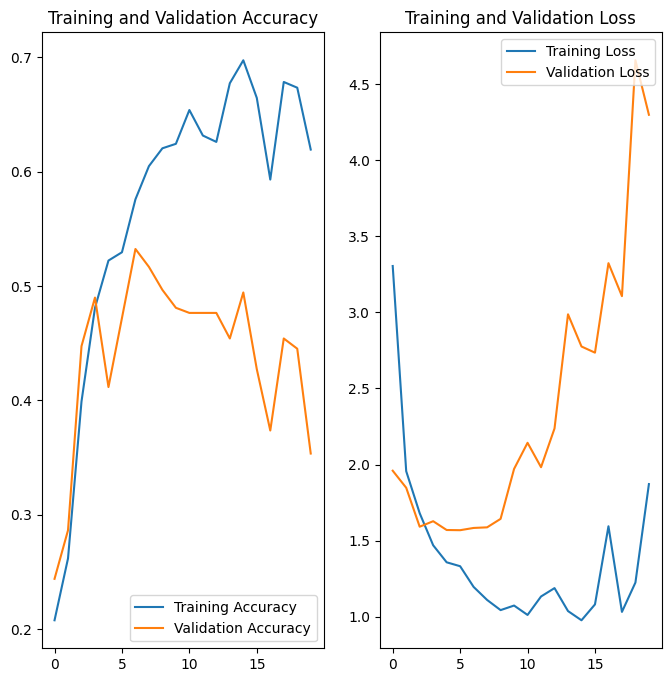

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
- There is clear evidence of an overfit here because the training accuracy is clearly significantly higher compared to the validation accuracy. The training accuracy is around 0.65 while the validation accuracy is around 0.4. 
- Overall, this model isn't performing too well and we can significantly improve it by adding some dropouts.

In [63]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = tf.keras.Sequential([
  RandomZoom(0.2),
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.2),
])

2024-12-16 23:20:57.292022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


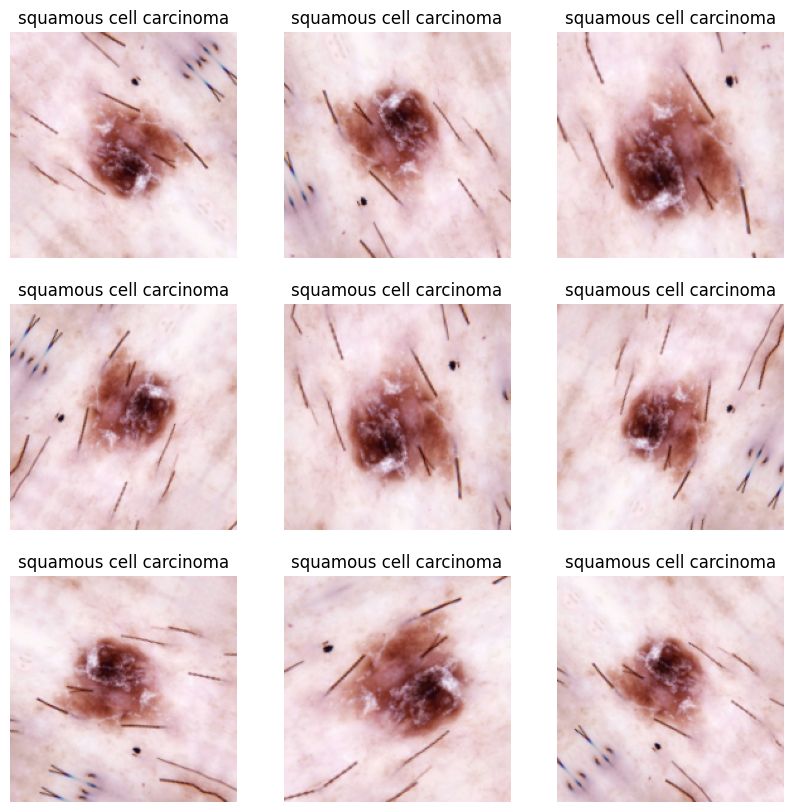

In [64]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

### Todo:
### Create the model, compile and train the model


In [33]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
num_classes = len(class_names)
model = Sequential()

# Input Layer
model.add(Input(shape=(img_height, img_width, 3)))
model.add(Rescaling(1./255))

# Block 1
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block 2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(num_classes, activation='softmax'))


### Compiling the model

In [34]:
## Your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 129600)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    16,588,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,609,481 (63.36 MB)

 Trainable params: 16,609,481 (63.36 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model (run this)

In [36]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.1527 - loss: 11.1883 - val_accuracy: 0.1499 - val_loss: 2.0747
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.2221 - loss: 2.0789 - val_accuracy: 0.1924 - val_loss: 2.0612
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.2149 - loss: 2.0725 - val_accuracy: 0.2908 - val_loss: 1.9893
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.3124 - loss: 1.9026 - val_accuracy: 0.3177 - val_loss: 1.8840
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.3515 - loss: 1.8098 - val_accuracy: 0.3333 - val_loss: 1.8791
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.3917 - loss: 1.7424 - val_accuracy: 0.3512 - val_loss: 1.7540
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.4327 - loss: 1.6300 - val_accuracy: 0.3333 - val_loss: 1.7790
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.4400 - loss: 1.5671 - val_accuracy: 0.5034 - 

### Visualizing the results

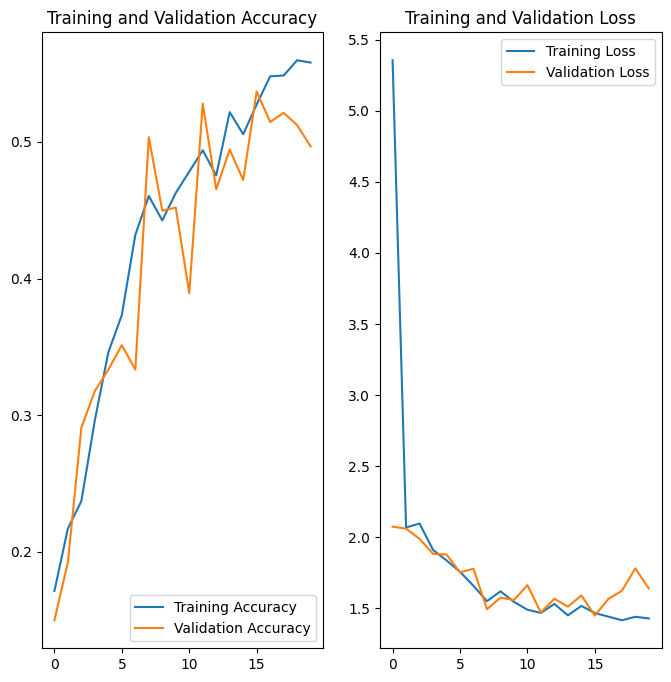

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

After adding additional drop out layers, the training accuracy was 0.5532 while the validation accuracy was 0.4966. This shows an improvement as compared to the previous model run, where there was larger difference in the training and validation accuracies.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [38]:
## Your code goes here.
# Check the class distribution in the training dataset
class_counts = {}
for images, labels in train_ds:
    for label in labels.numpy():
        class_name = class_names[label]
        if class_name in class_counts:
            class_counts[class_name] += 1
        else:
            class_counts[class_name] = 1

# Print the class distribution
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

melanoma: 352
pigmented benign keratosis: 370
nevus: 277
basal cell carcinoma: 309
vascular lesion: 115
dermatofibroma: 77
squamous cell carcinoma: 142
seborrheic keratosis: 58
actinic keratosis: 92


2024-12-16 22:35:31.625250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
- seborrheic keratosis has the least number of samples with 58 samples
#### - Which classes dominate the data in terms proportionate number of samples?
- pigmented benign keratosis dominates the data in terms of samples with the number being 370.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [39]:
!pip install Augmentor


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [40]:
path_to_training_dataset="./Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x328433F50>: 100%|██████████| 500/500 [00:01<00:00, 434.06 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x325885C50>: 100%|██████████| 500/500 [00:01<00:00, 480.13 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x321825510>: 100%|██████████| 500/500 [00:01<00:00, 452.45 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x326CE8F10>: 100%|██████████| 500/500 [00:04<00:00, 115.71 Samples/s]                  


Initialised with 357 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x322E68D10>: 100%|██████████| 500/500 [00:04<00:00, 117.21 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x32C3F14D0>: 100%|██████████| 500/500 [00:01<00:00, 456.25 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x3283BA510>: 100%|██████████| 500/500 [00:02<00:00, 207.96 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x326CC2E90>: 100%|██████████| 500/500 [00:01<00:00, 455.31 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3283AD710>: 100%|██████████| 500/500 [00:01<00:00, 450.35 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [41]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [42]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [43]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [44]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [47]:
df2['Label'].value_counts()

Label
melanoma                      500
pigmented benign keratosis    500
nevus                         500
basal cell carcinoma          500
actinic keratosis             500
squamous cell carcinoma       500
vascular lesion               500
seborrheic keratosis          500
dermatofibroma                500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [48]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [49]:
data_dir_train="/Users/swapnilkelkar/Documents/PGD ML&AI/CNNs/Assignment-Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [50]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [51]:
model = Sequential()

# Input Layer
model.add(Input(shape=(img_height, img_width, 3)))
model.add(Rescaling(1./255))

# Block 1
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block 2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [52]:
## your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [53]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 90, 90, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 129600)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │    16,588,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,609,865 (63.36 MB)

 Trainable params: 16,609,673 (63.36 MB)

 Non-trainable params: 192 (768.00 B)

#### **Todo:**  Train your model

In [54]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.2396 - loss: 156.8184 - val_accuracy: 0.0898 - val_loss: 100.4813
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - accuracy: 0.3486 - loss: 136.5216 - val_accuracy: 0.1589 - val_loss: 80.4901
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - accuracy: 0.3938 - loss: 110.5089 - val_accuracy: 0.3333 - val_loss: 59.3954
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - accuracy: 0.4159 - loss: 115.7758 - val_accuracy: 0.5033 - val_loss: 63.0481
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - accuracy: 0.4400 - loss: 101.4443 - val_accuracy: 0.4996 - val_loss: 52.4726
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - accuracy: 0.4794 - loss: 77.7437 - val_accuracy: 0.5471 - val_loss: 54.6139
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - accuracy: 0.4792 - loss: 74.2381 - val_accuracy: 0.5338 - val_loss: 40.9140
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - accura

#### **Todo:**  Visualize the model results

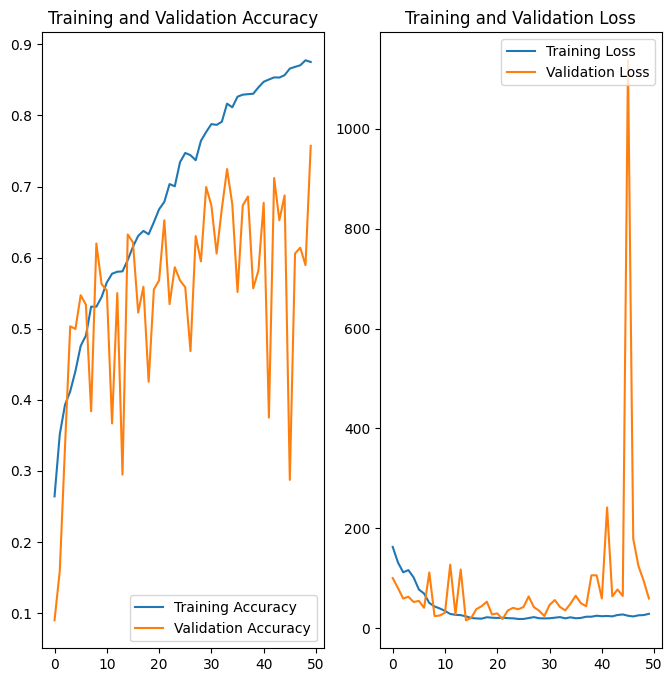

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Yes, I managed to address both underfitting and overfitting by implementing class rebalancing and augmentation. The class rebalancing proved particularly effective as it resulted in a more evenly distributed training dataset. This improvement was evident in the metrics, with the training accuracy reaching approximately 0.88 and the validation accuracy around 0.75.